# Autoencoder

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [23]:

# 1. Define the autoencoder model
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # [B, 16, 14, 14]
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # [B, 32, 7, 7]
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1, padding=1), # [B, 16, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, output_padding=1, padding=1),  # [B, 1, 28, 28]
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


In [24]:

transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



In [25]:

epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataset):.4f}")



Epoch 1/5, Loss: 0.0366
Epoch 2/5, Loss: 0.0016
Epoch 3/5, Loss: 0.0011
Epoch 4/5, Loss: 0.0008
Epoch 5/5, Loss: 0.0007


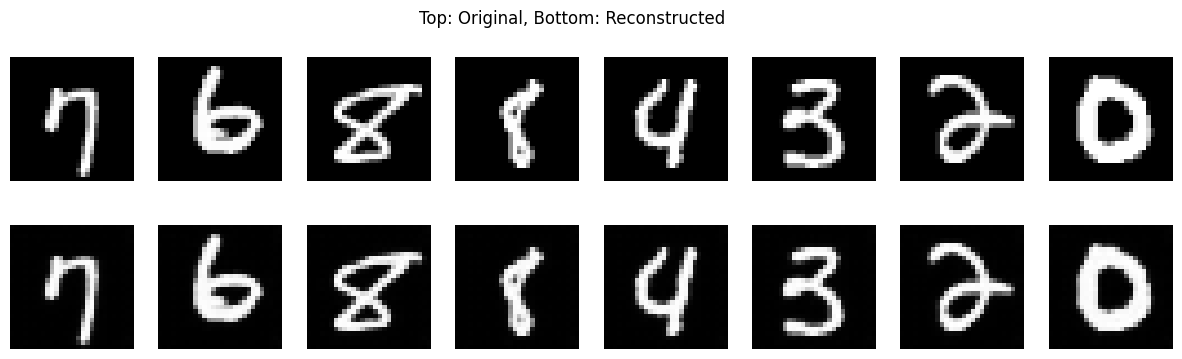

In [26]:

model.eval()
with torch.no_grad():
    sample_imgs, _ = next(iter(dataloader))
    sample_imgs = sample_imgs[:8].to(device)
    reconstructed = model(sample_imgs)

    # Plot
    fig, axes = plt.subplots(2, 8, figsize=(15, 4))
    for i in range(8):
        axes[0, i].imshow(sample_imgs[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
    plt.suptitle("Top: Original, Bottom: Reconstructed")
    plt.show()

### Try to use autoencoder as Anomaly Detection

In [38]:
import torch
import random

def add_artifact(images, size=18, color=0.0):
    """
    Add a square artifact (white or black) to a batch of images.
    """
    images = images.clone()
    print(images.shape)
    _, H, W = images.shape

    for img in images:
        x = random.randint(0, W - size)
        y = random.randint(0, H - size)
        img[y:y+size, x:x+size] = color

    return images

torch.Size([1, 28, 28])


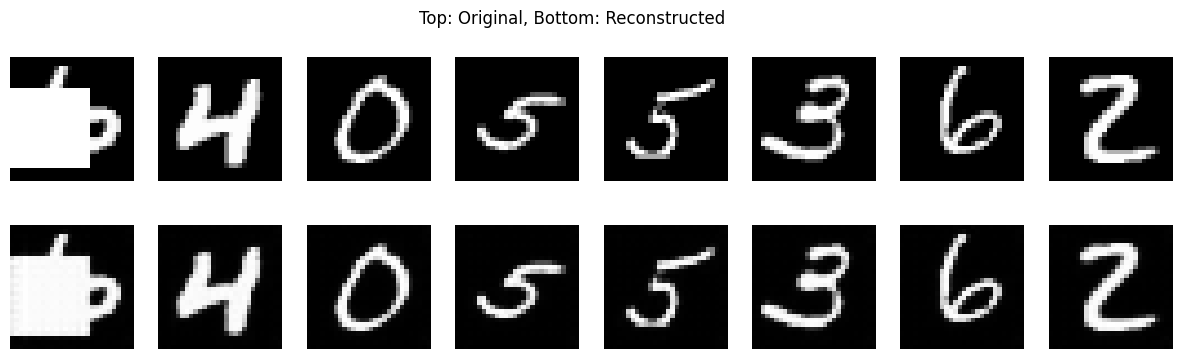

[tensor(18.1080), tensor(11.7705), tensor(10.4923), tensor(9.2629), tensor(10.8488), tensor(11.4341), tensor(10.4582), tensor(10.2594)]


In [49]:
from random import randrange


model.eval()
with torch.no_grad():
    smp = randrange(8)
    sample_imgs, _ = next(iter(dataloader))
    sample_imgs = sample_imgs[:8].to(device)
    sample_imgs[smp] = add_artifact(sample_imgs[smp], size=18, color=1.0)
    reconstructed = model(sample_imgs)
    errors = []
    # Plot
    fig, axes = plt.subplots(2, 8, figsize=(15, 4))
    for i in range(8):
        axes[0, i].imshow(sample_imgs[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
        errors.append(abs(sample_imgs[i]-reconstructed[i]).sum())
    plt.suptitle("Top: Original, Bottom: Reconstructed")
    plt.show()
    print(errors)

## AutoEncoder and the exploitation of latent space

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Autoencoder with latent vector
class ConvAutoencoderWithLatent(nn.Module):
    def __init__(self, latent_dim=32):
        super(ConvAutoencoderWithLatent, self).__init__()
        self.latent_dim = latent_dim

        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # [Batch, 16, 14, 14]
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # [Batch, 32, 7, 7]
            nn.ReLU(),
        )

        self.flatten = nn.Flatten()  # [Batch, 32*7*7]
        self.fc_enc = nn.Linear(32 * 7 * 7, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, 32 * 7 * 7)

        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, output_padding=1, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        z = self.fc_enc(x)
        return z

    def decode(self, z):
        x = self.fc_dec(z)
        x = x.view(-1, 32, 7, 7)
        x = self.decoder_cnn(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        out = self.decode(z)
        return out

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoderWithLatent(latent_dim=32).to(device)

transform = transforms.ToTensor()
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train
for epoch in range(5):
    model.train()
    total_loss = 0
    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataset):.4f}")

Epoch 1, Loss: 0.0291
Epoch 2, Loss: 0.0087
Epoch 3, Loss: 0.0073
Epoch 4, Loss: 0.0065
Epoch 5, Loss: 0.0060


In [53]:
from sklearn.manifold import TSNE
import numpy as np

model.eval()
latents = []
labels_tot = []

with torch.no_grad():
    for imgs, labels in DataLoader(dataset, batch_size=256):
        imgs = imgs.to(device)
        z = model.encode(imgs)  # [B, latent_dim]
        latents.append(z.cpu())
        labels_tot.extend(labels.cpu().numpy())

latents = torch.cat(latents).numpy()


In [54]:

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
latents_2d = tsne.fit_transform(latents)


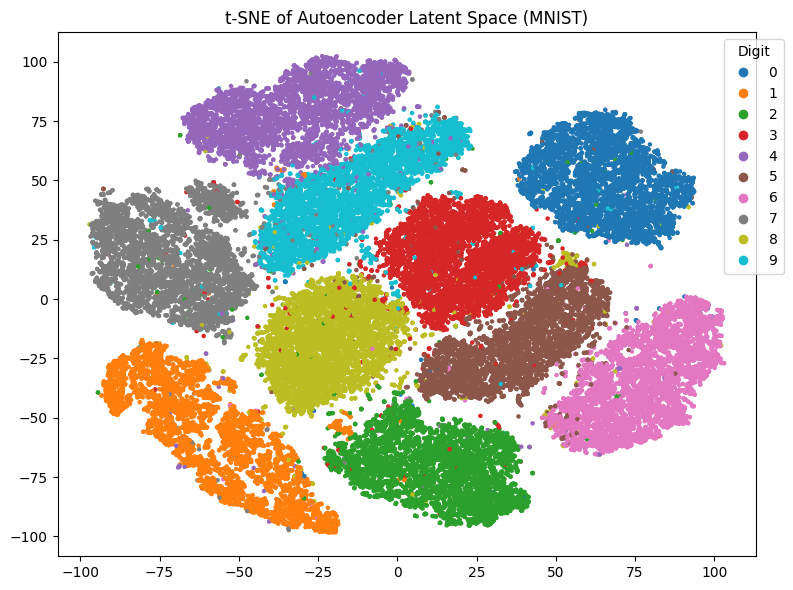

In [57]:

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels_tot, cmap='tab10', s=5)
plt.legend(*scatter.legend_elements(), title="Digit", bbox_to_anchor=(1.05, 1))
plt.title("t-SNE of Autoencoder Latent Space (MNIST)")
plt.tight_layout()
plt.show()